In [40]:
import numpy as np
import shutil
import os
import tensorflow as tf
print(tf.__version__)

1.10.1


In [41]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)
(55000, 10)


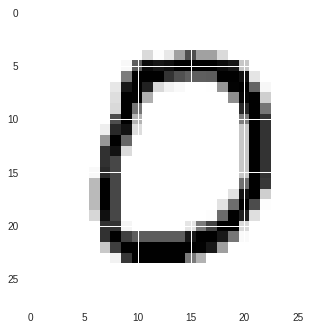

In [42]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

import matplotlib.pyplot as plt
IMGNO = 10
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

In [0]:
#Using low-level tensorflow
def linear_model(img, mode, hparams):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  W = tf.get_variable("W", [HEIGHT*WIDTH,NCLASSES], 
                      initializer = tf.truncated_normal_initializer(stddev=0.1,seed = 1))
  b = tf.get_variable("b",NCLASSES, initializer = tf.zeros_initializer)
  ylogits = tf.matmul(X,W)+b
  return ylogits, NCLASSES

In [0]:
#Using tf.layers API
def linear_model(img, mode, hparams):
  X = tf.reshape(img,[-1,HEIGHT*WIDTH]) #flatten
  ylogits = tf.layers.dense(X,NCLASSES,activation=None)
  return ylogits, NCLASSES

def dnn_model(img):
  X =  tf.reshape(img, [-1, HEIGHT * WIDTH]) #flatten
  h1 = tf.layers.dense(X, 300, activation=tf.nn.relu)
  h2 = tf.layers.dense(h1, 100, activation=tf.nn.relu)
  h3 = tf.layers.dense(h2, 30, activation=tf.nn.relu)
  
  ylogits = tf.layers.dense(h3, NCLASSES, activation=None)
  
  return ylogits, NCLASSES

def dnn_dropout_model(img, mode, hparams):
  dprob = hparams.get('dprob', 0.1)
  X =  tf.reshape(img, [-1, HEIGHT * WIDTH]) #flatten
  h1 = tf.layers.dense(X, 300, activation=tf.nn.relu)
  h2 = tf.layers.dense(h1, 100, activation=tf.nn.relu)
  h3 = tf.layers.dense(h2, 30, activation=tf.nn.relu)
  h3d = tf.layers.dropout(h3, rate=dprob, training=(
                          mode==tf.estimator.ModeKeys.TRAIN)) #Only dropout when training
  ylogits = tf.layers.dense(h3d, NCLASSES, activation=None)
  return ylogits, hparams

def cnn_model(img, mode, hparams):
  ksize1 = hparams.get('ksize1', 5)
  ksize2 = hparams.get('ksize2', 5)
  nfil1 = hparams.get('nfil1', 10)
  nfil2 = hparams.get('nfil2', 20)
  dprob = hparams.get('dprob', 0.25)
  
  c1 = tf.layers.conv2d(img, filters = nfil1,
                        kernel_size=ksize1,
                        strides = 1, #?X28X28X10
                        padding = 'same',
                        activation='relu')
  p1 = tf.layers.max_pooling2d(c1, pool_size=2, strides=2) #?X14X14X10
  c2 = tf.layers.conv2d(p1, filters=nfil2,
                        kernel_size=ksize2,
                        strides= 1,
                        padding='same',
                        activation='relu')
  p2 = tf.layers.max_pooling2d(c2, pool_size=2, strides=2) #?X7X7X20
  
  outlen = p2.shape[1]*p2.shape[2]*p2.shape[3] #980
  p2flat = tf.reshape(p2, [-1, outlen]) #flattened
  
  #apply batc normalization
  if hparams['batch_norm']:
    h3 = tf.layers.dense(p2flat, 300, activation=None)
    h3 = tf.layers.batch_normalization(
      h3, training=(mode==tf.estimator.ModeKeys.TRAIN)) #Only Batchnorm when training
    h3 = tf.nn.relu(h3)
  else:
    h3 = tf.layers.dense(p2flat, 300, activation=tf.nn.relu)

  #Apply dropout
  h3d = tf.layers.dense(h3, NCLASSES, activation=None)
  ylogits = tf.layers.dense(h3d, NCLASSES, activation=None)
  
  #Apply batch normalization once more
  if hparams['batch_norm']:
    ylogits = tf.layers.batch_normalization(
                    ylogits, training=(mode==tf.estimator.ModeKeys.TRAIN))
  return ylogits, hparams

In [0]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.train.images},
    y=mnist.train.labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True,
    queue_capacity=5000
  )

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'image':mnist.test.images},
    y=mnist.test.labels,
    batch_size=100,
    num_epochs=1,
    shuffle=False,
    queue_capacity=5000
  )

def serving_input_fn():
  #input will be rank 3
  feature_placeholders = {
      'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
  #But model function requires rank 4  
  features = {
      'image': tf.expand_dims(feature_placeholders['image'], -1)}
  
  return tf.estimator.export.ServingInputReceiver(features, 
                                                  feature_placeholders)

In [0]:
def image_classifier(features, labels, mode, params):
  #ylogits, nclasses = linear_model(features['image'])
  model_functions = {
        'linear': linear_model,
        'dnn': dnn_model,
        'dnn_dropout': dnn_dropout_model,
        'cnn': cnn_model}
  model_function = model_functions[params['model']]
  ylogits, n_classes = model_function(features['image'], mode, params)
  
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=ylogits, 
                                                                     labels=labels))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, 
                                                    tf.argmax(labels, 1))}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'], 
                                                               optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput(
            {"probabilities": probabilities, 
             "classes": classes})}
    )

In [0]:
def train_and_evaluate(output_dir, hparams):
  EVAL_INTERVAL = 60
  estimator = tf.estimator.Estimator(model_fn = image_classifier,
                                     params = hparams,
                                     config=tf.estimator.RunConfig(
                                         save_checkpoints_secs = EVAL_INTERVAL),
                                     model_dir = output_dir)
  train_spec = tf.estimator.TrainSpec(input_fn = train_input_fn,
                                    max_steps = hparams['train_steps'])
  exporter = tf.estimator.LatestExporter('Servo', serving_input_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn = eval_input_fn,
                                  steps = None,
                                  exporters = exporter)
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [71]:
OUTDIR='mnist/learned'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

hparams = {'model': 'cnn', 
           'batch_norm': 1,
           'train_steps': 1000, 
           'learning_rate': 0.01}
train_and_evaluate(OUTDIR, hparams)

INFO:tensorflow:Using config: {'_model_dir': 'mnist/learned', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 60, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0aeecc7908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 60.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_